#### Turn data into a panda dataframe with the following 6 title columns:

In [106]:
import numpy as np
import pandas as pd
info=np.load("finaldata.npy")
info2=pd.DataFrame(info,columns=['time','low','high','open','close','volume'])


In [109]:
print(info2.head())
print(info2.tail())

           time      low     high     open    close     volume
0  1.512119e+09  9752.26  9819.99  9790.06  9756.35  22.554360
1  1.512119e+09  9748.28  9805.00  9756.02  9787.00  16.334493
2  1.512119e+09  9787.00  9817.00  9787.00  9810.27  21.441774
3  1.512120e+09  9770.00  9816.78  9810.31  9771.90  30.926456
4  1.512120e+09  9771.90  9807.85  9771.90  9805.38  16.960849
              time       low      high      open     close     volume
2090  1.512747e+09  15889.18  16166.65  16000.00  15999.99  38.879872
2091  1.512748e+09  15975.01  16049.98  15999.99  16019.12  37.219797
2092  1.512748e+09  15925.00  16082.02  16019.12  15925.09  57.588199
2093  1.512748e+09  15752.08  15999.99  15929.87  15765.99  43.889727
2094  1.512748e+09  15760.10  15985.00  15760.11  15900.00  26.743069


 We have 2095 rows of data, instead of 2100. Since records are taken every 5 minutes, if there is no missing data, the difference between time stamps has to be 300 seconds. 

  Below, we find out that data is missing right after row number 1824 (indexed by 1823), and the following 5 entries spread out each 300 seconds are missing. 

In [110]:
for i in range(len(info)-1):
    if info[i+1][0]-info[i][0]!=300:
        print(i)
        print(info[i])
        print(info[i+1])
        print(info[i+1][0]-info[i][0])       

1823
[  1.51266570e+09   1.51972600e+04   1.63979600e+04   1.51972600e+04
   1.62999900e+04   2.51009043e+01]
[  1.51266750e+09   1.51000000e+04   1.62600100e+04   1.62600100e+04
   1.62499800e+04   1.36341209e+01]
1800.0


### Missing data: 
  Since the fraction of missing data is very small, it shouldn't affect the trading rules too much, so we'll refrain from imputation methods. 
  However, when calculating the new "Market Returns" column below, we have to make sure to prorate the returns from row indexed 1823 to row indexed 1824 (since those returns were obtained in 25 min as opposed to 5 min).



In [111]:
info2['Market Returns']=(info2['close']-info2['close'].shift(1))/info2['close'].shift(1)
info2['Market Returns'][1823]=0.2*info2['Market Returns'][1823]

### Plotting the 5-minute closing prices

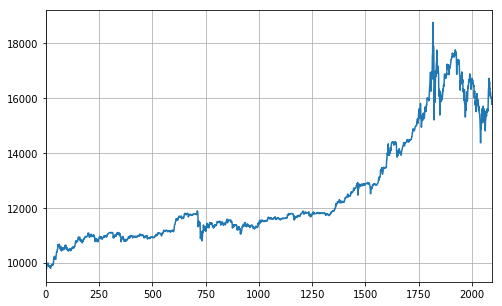

In [84]:
import pylab
info2['close'].plot(grid=True,figsize=(8,5))
pylab.show()

### Plotting the close-to-close 5-minute returns

  The large deviation around 1800 is probably due to the crude substitution of the returns during the missing period.

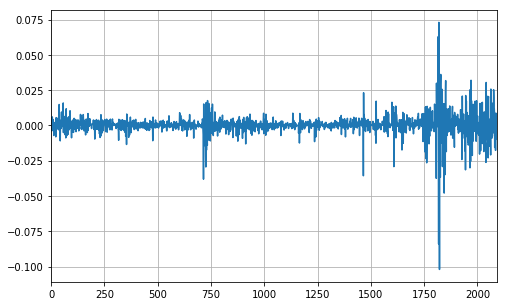

In [112]:
import pylab
info2['Market Returns'].plot(grid=True,figsize=(8,5))
pylab.show()

### Plotting the 5-minute volumes

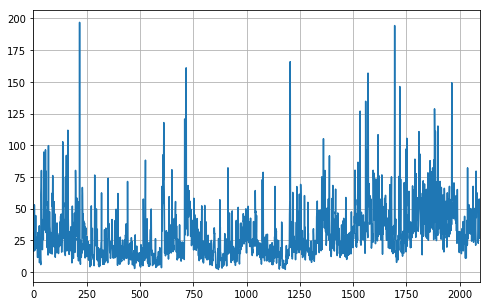

In [113]:
import pylab
info2['volume'].plot(grid=True,figsize=(8,5))
pylab.show()

### Moving Average crossover trading strategy:

 Buy signal when short-term average exceeds long-term average.
 Sell signal when short-term average goes below long-term average (subject to a percentage b).
 
 The paper lists the original BLL trading rules: b=0.01, c=10, n1=1,2,3 (fast MA), n2=50,150,200 (slow MA)
 
 We follow their suggestions and keep the time delay filter d < c.
 
 Since our dataset is in 5-min ranges, instead of days, we increase n1 to 5 and 10.
 

In [123]:
b=0.01
c=10
n1a=5
n1b=10   #fast MA
n2a=50   #slow MA
n2b=150
d=5

# below: we calculate moving arerages
info2['fast1a'] = np.round(info2['close'].rolling(window=n1a).mean(),2)
info2['fast1b'] = np.round(info2['close'].rolling(window=n1b).mean(),2)
info2['slow2a'] = np.round(info2['close'].rolling(window=n2a).mean(),2)
info2['slow2b'] = np.round(info2['close'].rolling(window=n2b).mean(),2)
info2.tail()

,time,low,high,open,close,volume,Market Returns,golden_cross_1a_2a,fast1a,fast1b,slow2a,slow2b
2090,1.512747e+09,15889.18,16166.65,16000.00,15999.99,38.879872,-6.250000e-07,0,16069.20,16213.32,15634.10,15994.46
2091,1.512748e+09,15975.01,16049.98,15999.99,16019.12,37.219797,1.195626e-03,0,16032.96,16170.24,15658.49,15988.25
2092,1.512748e+09,15925.00,16082.02,16019.12,15925.09,57.588199,-5.869861e-03,0,15991.84,16103.97,15677.00,15982.32
2093,1.512748e+09,15752.08,15999.99,15929.87,15765.99,43.889727,-9.990524e-03,0,15942.04,16046.71,15695.32,15975.37
2094,1.512748e+09,15760.10,15985.00,15760.11,15900.00,26.743069,8.499942e-03,0,15922.04,16001.71,15710.12,15972.83


### Count [ potential ] buy/sell signals

  We haven't factored in the waiting periods, yet.
  
  The counts below show how many "potential" buy/sell/neutral signals we get every day.
  1-buy, -1-sell, 0-hold

In [124]:
info2['cross_1a_2a']=0
info2['cross_1a_2a']=np.where(info2['fast1a']-(1+b)*info2['slow2a'] > 0, 1, 0)    # 1 - buy signal 
info2['cross_1a_2a'] = np.where(-info2['fast1a']*(1+b)+info2['slow2a'] > 0 , -1, info2['cross_1a_2a'])    # -1 - sell signal
print(info2['cross_1a_2a'].value_counts())

info2['cross_1a_2b']=0
info2['cross_1a_2b']=np.where(info2['fast1a']-(1+b)*info2['slow2b'] > 0, 1, 0)    # 1 - buy signal 
info2['cross_1a_2b'] = np.where(-info2['fast1a']*(1+b)+info2['slow2b'] > 0 , -1, info2['cross_1a_2b'])    # -1 - sell signal
print(info2['cross_1a_2b'].value_counts())

info2['cross_1b_2a']=0
info2['cross_1b_2a']=np.where(info2['fast1b']-(1+b)*info2['slow2a'] > 0, 1, 0)    # 1 - buy signal 
info2['cross_1b_2a'] = np.where(-info2['fast1b']*(1+b)+info2['slow2a'] > 0 , -1, info2['cross_1b_2a'])    # -1 - sell signal
print(info2['cross_1b_2a'].value_counts())

info2['cross_1b_2b']=0
info2['cross_1b_2b']=np.where(info2['fast1b']-(1+b)*info2['slow2b'] > 0, 1, 0)    # 1 - buy signal 
info2['cross_1b_2b'] = np.where(-info2['fast1b']*(1+b)+info2['slow2b'] > 0 , -1, info2['cross_1b_2b'])    # -1 - sell signal
print(info2['cross_1b_2b'].value_counts())



info2.tail()

 0    1238
 1     621
-1     236
Name: cross_1a_2a, dtype: int64
 1    1022
 0     833
-1     240
Name: cross_1a_2b, dtype: int64
 0    1334
 1     549
-1     212
Name: cross_1b_2a, dtype: int64
 1    1014
 0     844
-1     237
Name: cross_1b_2b, dtype: int64


,time,low,high,open,close,volume,Market Returns,golden_cross_1a_2a,fast1a,fast1b,slow2a,slow2b,cross_1a_2a,cross_1a_2b,cross_1b_2a,cross_1b_2b
2090,1.512747e+09,15889.18,16166.65,16000.00,15999.99,38.879872,-6.250000e-07,0,16069.20,16213.32,15634.10,15994.46,1,0,1,1
2091,1.512748e+09,15975.01,16049.98,15999.99,16019.12,37.219797,1.195626e-03,0,16032.96,16170.24,15658.49,15988.25,1,0,1,1
2092,1.512748e+09,15925.00,16082.02,16019.12,15925.09,57.588199,-5.869861e-03,0,15991.84,16103.97,15677.00,15982.32,1,0,1,0
2093,1.512748e+09,15752.08,15999.99,15929.87,15765.99,43.889727,-9.990524e-03,0,15942.04,16046.71,15695.32,15975.37,1,0,1,0
2094,1.512748e+09,15760.10,15985.00,15760.11,15900.00,26.743069,8.499942e-03,0,15922.04,16001.71,15710.12,15972.83,1,0,1,0


Next, we check if the crossover has been happening for d days and if the position was held for c days, for each potential signal in the "cross" columns.

In [126]:
l=2095
info2['golden_cross_1a_2a']=0
# remember d<c
for i in range(c,l): 
    if info2['cross_1a_2a'][i]==1 and all(info2['golden_cross_1a_2a'][j]==0 for j in range(i-c,i)) and all(info2['cross_1a_2a'][j]==1 for j in range(i-d,i)):
        info2['golden_cross_1a_2a'][i]=1
    elif info2['cross_1a_2a'][i]==-1 and all(info2['golden_cross_1a_2a'][j]==0 for j in range(i-c,i)) and all(info2['cross_1a_2a'][j]==-1 for j in range(i-d,i)):
        info2['golden_cross_1a_2a'][i]=-1  
print(info2['golden_cross_1a_2a'].value_counts())   

info2['golden_cross_1a_2b']=0
for i in range(c,l): 
    if info2['cross_1a_2b'][i]==1 and all(info2['golden_cross_1a_2b'][j]==0 for j in range(i-c,i)) and all(info2['cross_1a_2b'][j]==1 for j in range(i-d,i)):
        info2['golden_cross_1a_2a'][i]=1
    elif info2['cross_1a_2b'][i]==-1 and all(info2['golden_cross_1a_2b'][j]==0 for j in range(i-c,i)) and all(info2['cross_1a_2b'][j]==-1 for j in range(i-d,i)):
        info2['golden_cross_1a_2b'][i]=-1  
print(info2['golden_cross_1a_2b'].value_counts())   

info2['golden_cross_1b_2a']=0
for i in range(c,l): 
    if info2['cross_1b_2a'][i]==1 and all(info2['golden_cross_1b_2a'][j]==0 for j in range(i-c,i)) and all(info2['cross_1b_2a'][j]==1 for j in range(i-d,i)):
        info2['golden_cross_1b_2a'][i]=1
    elif info2['cross_1b_2a'][i]==-1 and all(info2['golden_cross_1b_2a'][j]==0 for j in range(i-c,i)) and all(info2['cross_1b_2a'][j]==-1 for j in range(i-d,i)):
        info2['golden_cross_1b_2a'][i]=-1  
print(info2['golden_cross_1b_2a'].value_counts())   

info2['golden_cross_1b_2b']=0
for i in range(c,l): 
    if info2['cross_1b_2b'][i]==1 and all(info2['golden_cross_1b_2b'][j]==0 for j in range(i-c,i)) and all(info2['cross_1b_2b'][j]==1 for j in range(i-d,i)):
        info2['golden_cross_1a_2a'][i]=1
    elif info2['cross_1b_2b'][i]==-1 and all(info2['golden_cross_1b_2b'][j]==0 for j in range(i-c,i)) and all(info2['cross_1b_2b'][j]==-1 for j in range(i-d,i)):
        info2['golden_cross_1b_2b'][i]=-1  
print(info2['golden_cross_1b_2b'].value_counts())   

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


 0    2017
 1      55
-1      23
Name: golden_cross_1a_2a, dtype: int64


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


 0    2074
-1      21
Name: golden_cross_1a_2b, dtype: int64


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 0    2026
 1      49
-1      20
Name: golden_cross_1b_2a, dtype: int64


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 0    2074
-1      21
Name: golden_cross_1b_2b, dtype: int64


### The 4 columns "golden_cross" show the buy (1)/sell(-1)/neutral(0) signals for all 4 strategies.

In [127]:
info2['Strategy_1'] = info2['Market Returns'] * info2['golden_cross_1a_2a'].shift(1)
info2['Strategy_2'] = info2['Market Returns'] * info2['golden_cross_1a_2b'].shift(1)
info2['Strategy_3'] = info2['Market Returns'] * info2['golden_cross_1b_2a'].shift(1)
info2['Strategy_4'] = info2['Market Returns'] * info2['golden_cross_1b_2b'].shift(1)

### The plot below shows cummulative returns over the 4 strategies and the buy-and-hold strategy.

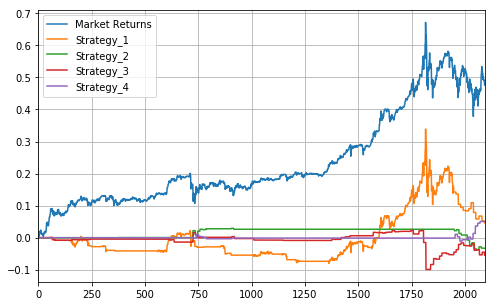

In [128]:
info2[['Market Returns','Strategy_1','Strategy_2','Strategy_3','Strategy_4']].cumsum().plot(grid=True,figsize=(8,5))
pylab.show()

### Next, we apply stationary bootstrap method

  Loss function - in the paper, eqn(2),p.1651 - difference in log returns.

In [161]:

from arch.bootstrap import StationaryBootstrap
bs = StationaryBootstrap(12, info2['Market Returns'],info2['Strategy_1'],info2['Strategy_2'],info2['Strategy_3'],info2['Strategy_4'])
import math
import numpy as np
import pandas as pd

def loss_fun(mat,alt1,alt2,alt3,alt4):
    f1 =np.asarray([math.log1p(i) for i in alt1])
    fmat=np.asarray([math.log1p(j) for j in mat])
    f2 =np.asarray([math.log1p(i) for i in alt2])
    f3 =np.asarray([math.log1p(i) for i in alt3])
    f4 =np.asarray([math.log1p(i) for i in alt4])
    f1d=f1-fmat
    f2d=f2-fmat
    f3d=f3-fmat
    f4d=f4-fmat
    ss=np.array([np.mean(f1d[1:]),np.mean(f2d[1:]),np.mean(f3d[1:]),np.mean(f4d[1:])])
    return ss

a1=loss_fun(info2.as_matrix(columns=['Market Returns']),info2.as_matrix(columns=['Strategy_1']),info2.as_matrix(columns=['Strategy_2']),info2.as_matrix(columns=['Strategy_3']),info2.as_matrix(columns=['Strategy_4']))
print('Exact difference in cummulative returns, strategy 1:',a1)


Exact difference in cummulative returns, strategy 1: [-0.00020203 -0.0002228  -0.0002361  -0.00018284]


### Calculate 2500x4 matrix, consisting of the difference in log returns between the 4 strategies and the benchmark, over each of the 2500 bootstrapped subsamples.

In [175]:
results = bs.apply(loss_fun, 2500)   #fstarroof=results
print(results)
print(bs)

[[        nan         nan         nan         nan]
 [-0.00020813 -0.00042063 -0.00048941 -0.00039603]
 [        nan         nan         nan         nan]
 ..., 
 [-0.00023362 -0.00045606 -0.0005158  -0.00042207]
 [        nan         nan         nan         nan]
 [        nan         nan         nan         nan]]
Stationary Bootstrap(block size: 12, no. pos. inputs: 5, no. keyword inputs: 0)


### White Reality Check

  The null hypothesis is that we haven't found an outperforming strategy.

In [185]:
import pandas as pd
froof = max(a1)
n=2095
Vl = (n)**(0.5)*froof

delta=np.zeros((2500,4))
for i in range(2500):
    delta[i,:]=results[i,:]-np.transpose(a1)

max_delta=np.amax(delta,axis=1)
#print(max_delta.shape)

Vlstar=(n)**(0.5)*max_delta

Vlstar = np.sort(Vlstar)
better = Vlstar>Vl
pvalue = sum(better)/n
print(pvalue)

0.440095465394


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


## The p-value is 0.44. We fail to reject the hypothesis that we have not found an outperforming strategy.
### We conclude that the benchmark buy-and-hold isn't outperformed by the 4 trading rules that we test.